# **Import Libraries**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score, matthews_corrcoef, f1_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# **Preprocessing** 

### Cleaning the Data

In [2]:
data = pd.read_csv("Pokemon.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB
None


In [3]:
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
# add your code here for data cleaning of the adventure data set INCOME
data.duplicated().any()

False

In [5]:
data.isnull().any()

#             False
Name          False
Type 1        False
Type 2         True
Total         False
HP            False
Attack        False
Defense       False
Sp. Atk       False
Sp. Def       False
Speed         False
Generation    False
Legendary     False
dtype: bool

In [6]:
data['Type 2'] = data['Type 2'].fillna('None')

In [7]:
# Step 2: Encode the 'Type 1' column
type1_mapping = {type_: idx for idx, type_ in enumerate(data['Type 1'].unique())}
data['Type 1 Encoded'] = data['Type 1'].map(type1_mapping)

# Step 3: Encode the 'Type 2' column
type2_mapping = {type_: idx for idx, type_ in enumerate(data['Type 2'].unique())}
data['Type 2 Encoded'] = data['Type 2'].map(type2_mapping)

# Step 4: Drop the original 'Type 1' and 'Type 2' columns and replace them with encoded columns
data.drop(['Type 1', 'Type 2'], axis=1, inplace=True)
data.rename(columns={'Type 1 Encoded': 'Type 1', 'Type 2 Encoded': 'Type 2'}, inplace=True)

In [8]:
# Step 4: Convert 'Legendary' to 1s and 0s
data['Legendary'] = data['Legendary'].astype(int)

# Drop the 'Name' and '#' columns
data.drop(['#', 'Name'], axis=1, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Total       800 non-null    int64
 1   HP          800 non-null    int64
 2   Attack      800 non-null    int64
 3   Defense     800 non-null    int64
 4   Sp. Atk     800 non-null    int64
 5   Sp. Def     800 non-null    int64
 6   Speed       800 non-null    int64
 7   Generation  800 non-null    int64
 8   Legendary   800 non-null    int32
 9   Type 1      800 non-null    int64
 10  Type 2      800 non-null    int64
dtypes: int32(1), int64(10)
memory usage: 65.8 KB


In [10]:
data.describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Type 1,Type 2
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.00000,800.000000,800.00000
mean,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375,0.08125,6.306250,3.76250
std,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129,0.27339,4.876955,4.30049
min,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000,0.00000,0.000000,0.00000
25%,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000,0.00000,2.000000,1.00000
50%,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000,0.00000,4.000000,1.00000
75%,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000,0.00000,10.000000,6.00000
max,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000,1.00000,17.000000,18.00000


In [11]:
original_data = data.copy()

In [12]:
#data.drop(['Type 1', 'Type 2'], axis=1, inplace=True)

In [13]:
# normalize values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)
scaled_features.shape
data = pd.DataFrame(scaled_features, columns=data.columns)

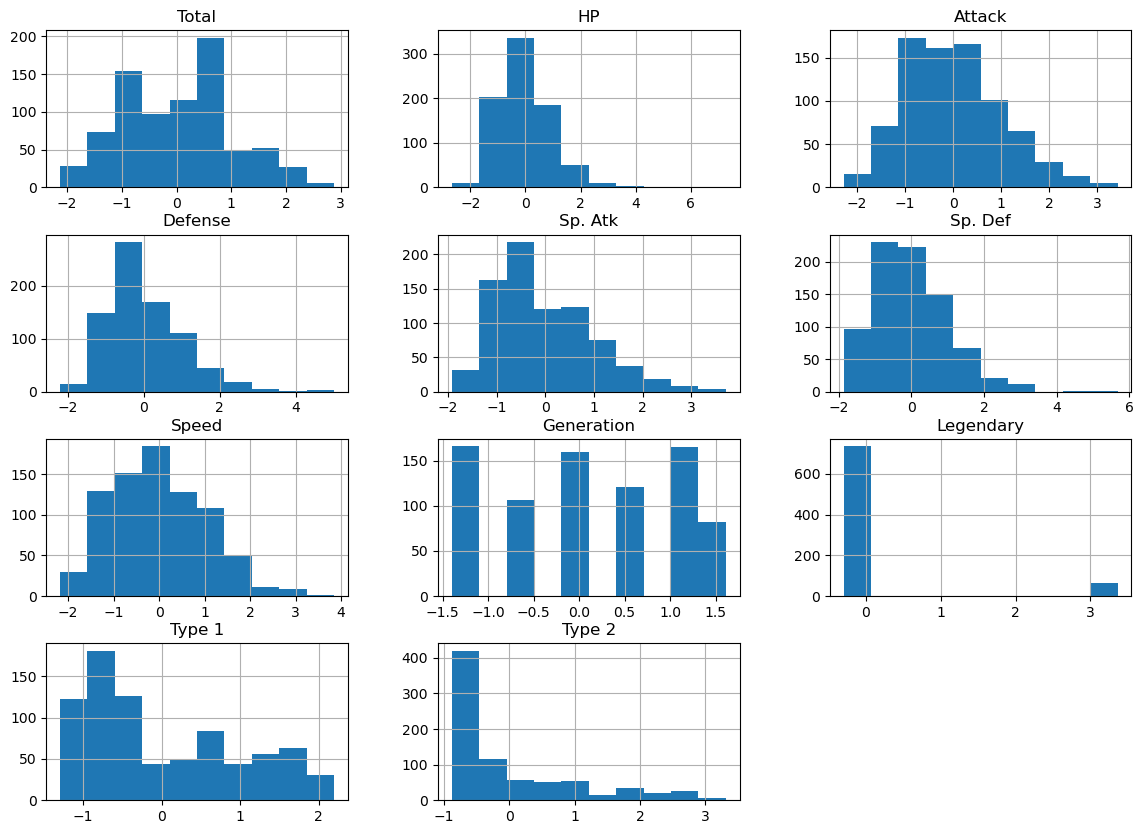

In [14]:
# Add visualizations here that you made to present insights in the adventure data. Create a new codeblock for every graph. Add markdown blocks to describe your graphs where necessary.
# Histograms for distribution
data.hist(figsize=(14, 10))
plt.show()

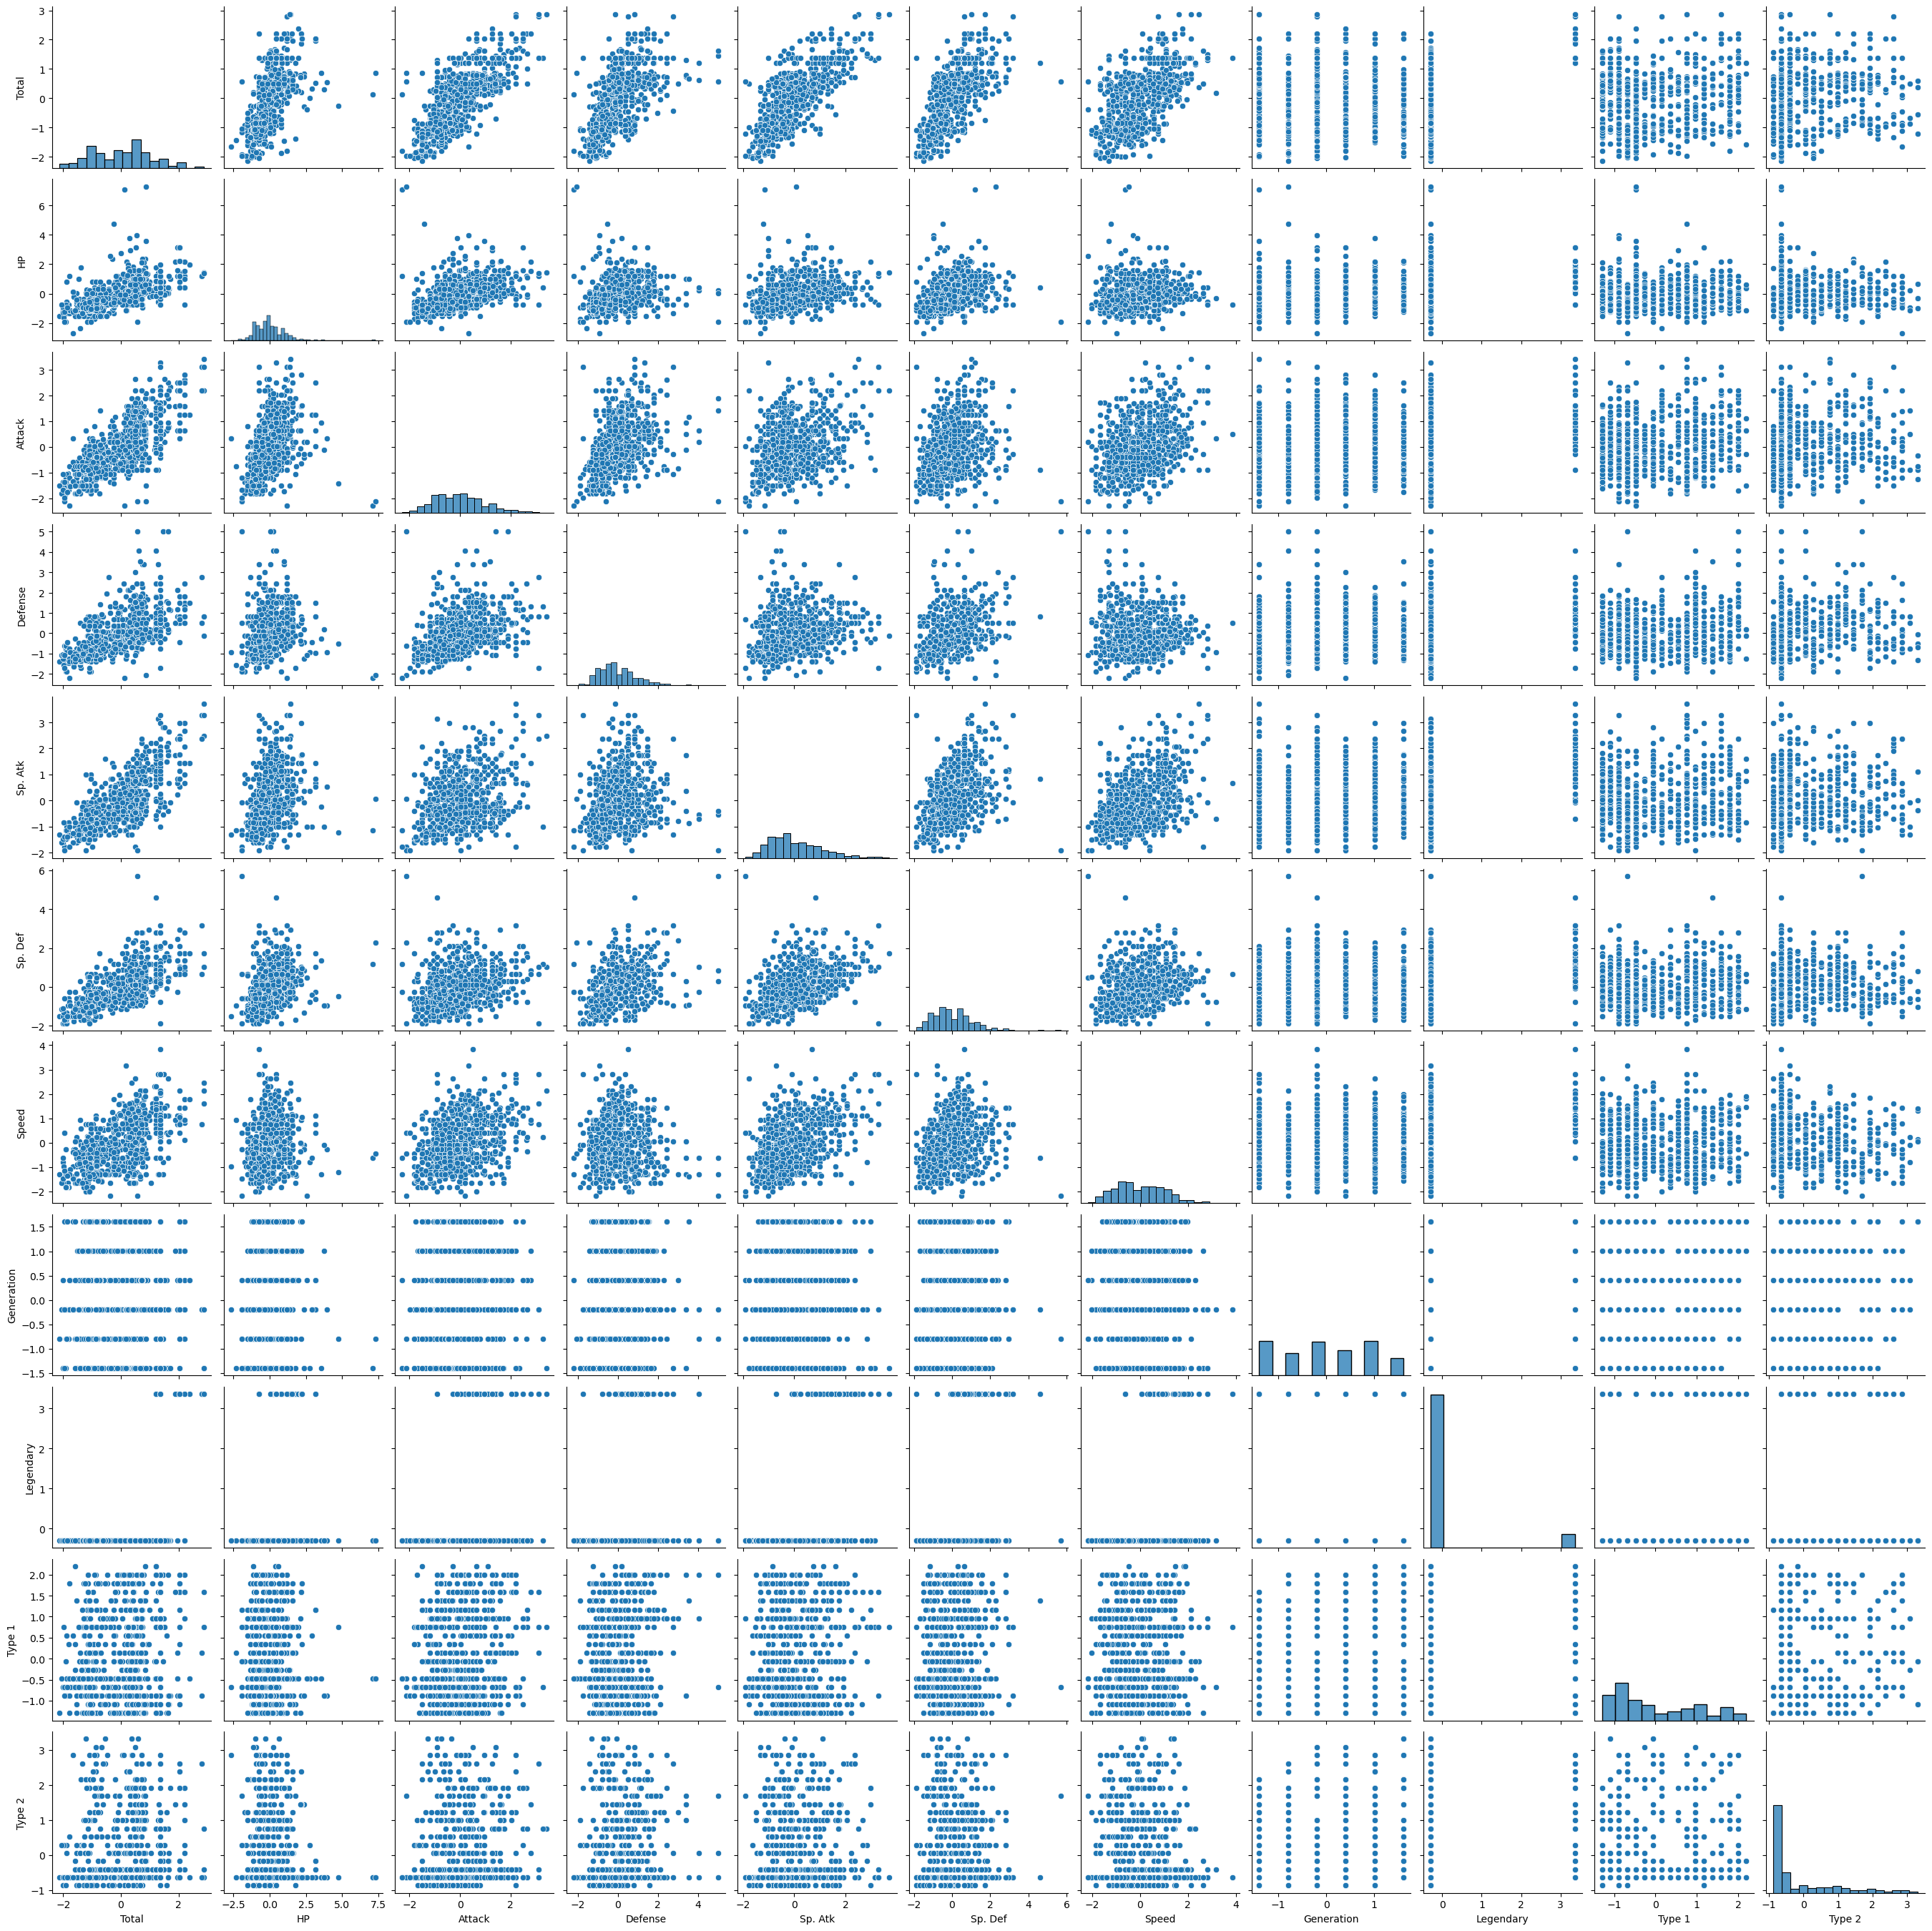

In [15]:
# Pairplot to see pairwise relationships
sns.pairplot(data)
plt.show()

<Axes: >

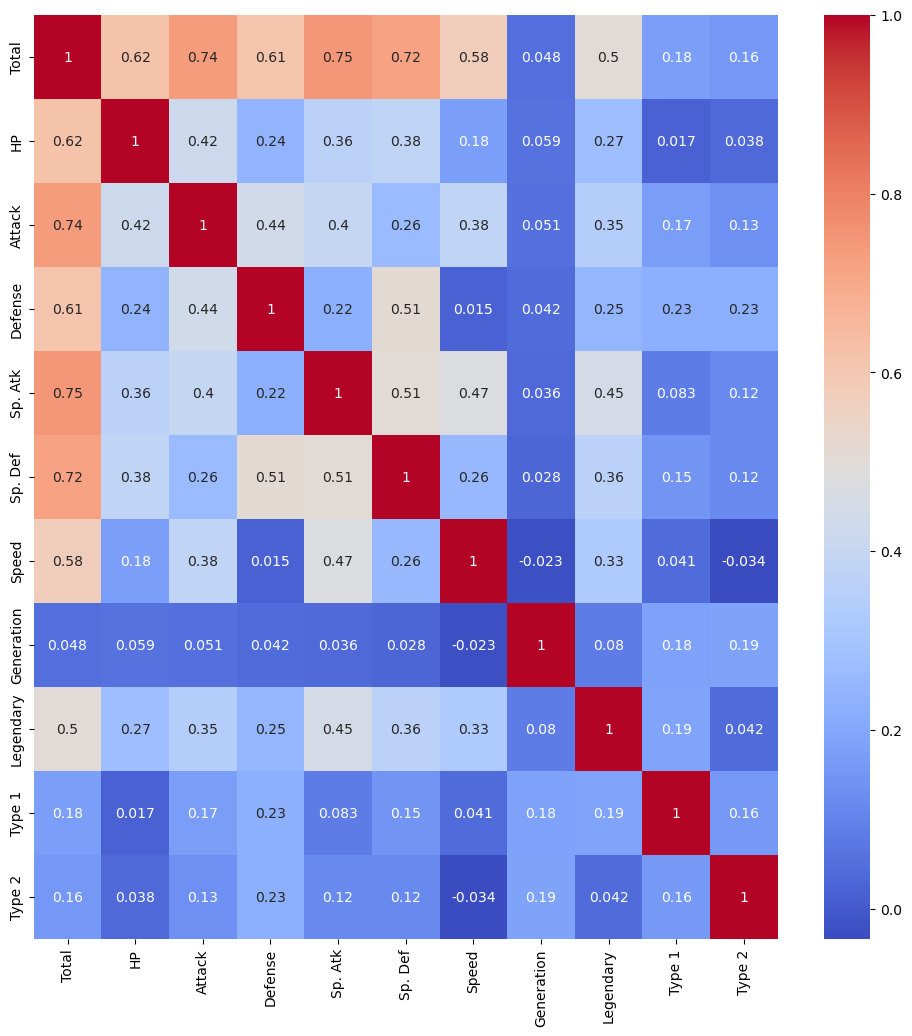

In [16]:
plt.figure(figsize = (12, 12))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', 
            xticklabels=data.columns,
            yticklabels=data.columns)

In [17]:
data.corr()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Type 1,Type 2
Total,1.000000,0.618748,0.736211,0.612787,0.747250,0.717609,0.575943,0.048384,0.501758,0.175177,0.155009
HP,0.618748,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620,0.017041,0.037647
Attack,0.736211,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408,0.169334,0.132419
Defense,0.612787,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377,0.228763,0.228598
Sp. Atk,0.747250,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907,0.082983,0.117869
Sp. Def,0.717609,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937,0.145101,0.119558
Speed,0.575943,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715,0.041169,-0.033602
Generation,0.048384,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794,0.180687,0.185958
Legendary,0.501758,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000,0.188765,0.041982
Type 1,0.175177,0.017041,0.169334,0.228763,0.082983,0.145101,0.041169,0.180687,0.188765,1.000000,0.159043


# **Unsuperviosed Learning**

# Kmean Clustering

In [18]:
Clustering = pd.DataFrame()

In [19]:
selected_columns = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
data_subset = data[selected_columns]

In [20]:
def plot_kmeans_inertia(data):
    inertia = []
    for x in range(2, 15):
        km = KMeans(n_clusters=x, init='k-means++', random_state=42)
        labels = km.fit_predict(data)
        inertia.append(km.inertia_)

    plt.figure(figsize=(12, 6))
    plt.plot(range(2, 15), inertia, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia plot with K before ignoring attributes')
    plt.xticks(list(range(2, 15)))

    # Determine the elbow point
    kneedle = KneeLocator(range(2, 15), inertia, curve='convex', direction='decreasing')
    elbow_point = kneedle.elbow
    if elbow_point is not None:
        plt.axvline(elbow_point, color='red', linestyle='--')
        plt.scatter(elbow_point, inertia[elbow_point - 2], color='red')
        print(f'Elbow point: (Clusters: {elbow_point}, Inertia: {inertia[elbow_point - 2]})')

    plt.show()

Elbow point: (Clusters: 7, Inertia: 2069.0392596258994)


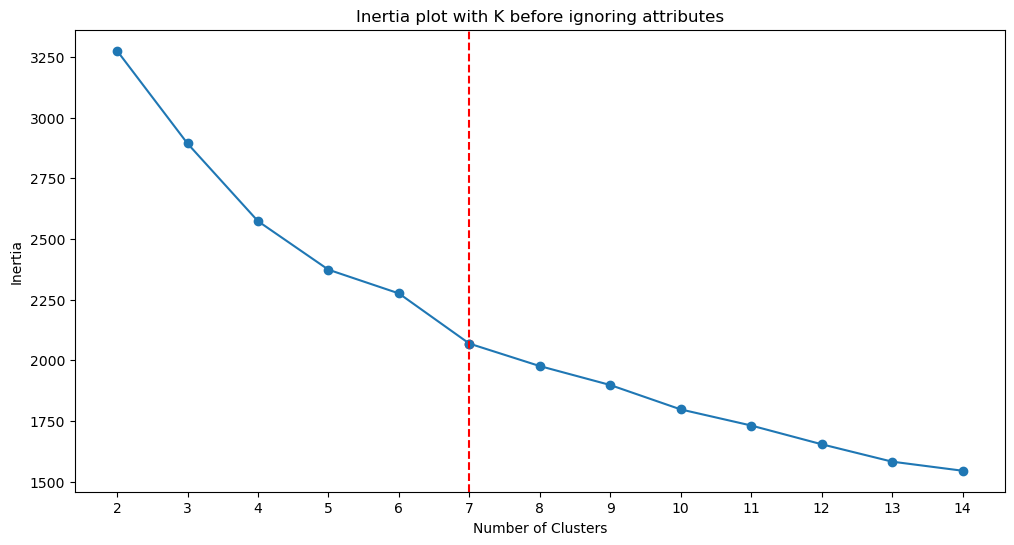

In [21]:
plot_kmeans_inertia(data_subset)

In [22]:
def visualize_kmeans_clusters(data, num_clusters, test_description, df):

    # Initialize K-means with 'k-means++' initialization
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    kmeans.fit(data)
    
    # Get cluster centers and labels
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # Save the cluster labels to the result dataframe
    df[f'Cluster_{num_clusters}_{test_description}'] = labels
    
    # Visualize the clusters using a scatter plot for the first two features
    plt.figure(figsize=(10, 6))
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='viridis', marker='o', label='Data Points')
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=300, c='red', label='Centroids', marker='x')
    plt.xlabel('Feature 1 (Scaled)')
    plt.ylabel('Feature 2 (Scaled)')
    plt.title(f'K-Means Clustering with K={num_clusters} {test_description}')
    plt.legend()
    plt.show()
    
    # Print the shape of scaled features and cluster centers for verification
    print(f'K={num_clusters}: Scaled features shape: {data.shape}')
    print(f'K={num_clusters}: Cluster centers shape: {cluster_centers.shape}')

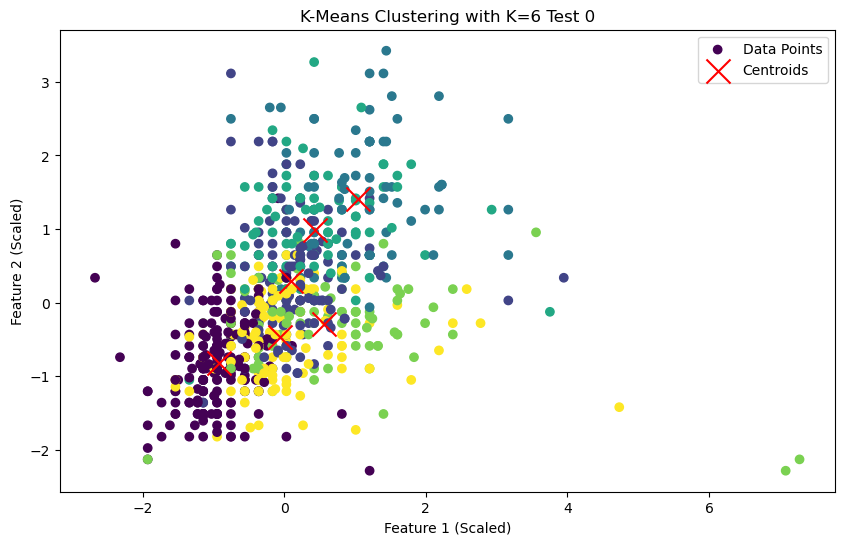

K=6: Scaled features shape: (800, 6)
K=6: Cluster centers shape: (6, 6)


In [23]:
visualize_kmeans_clusters(data_subset, 6,'Test 0', Clustering)

PCA with # of components: 1
Silhouette-Score for 2 Clusters: 0.5856474666049732        Inertia: 1147.2231524562044

PCA with # of components: 2
Silhouette-Score for 2 Clusters: 0.41520322115433755        Inertia: 2276.6522136224994

PCA with # of components: 3
Silhouette-Score for 2 Clusters: 0.34864722012827165        Inertia: 3102.530195620816

PCA with # of components: 4
Silhouette-Score for 2 Clusters: 0.30707143935615955        Inertia: 3811.2076806417135

PCA with # of components: 5
Silhouette-Score for 2 Clusters: 0.27724831624061574        Inertia: 4477.025301992359

PCA with # of components: 6
Silhouette-Score for 2 Clusters: 0.2546174081058277        Inertia: 5102.771978919596

PCA with # of components: 7
Silhouette-Score for 2 Clusters: 0.24288736162756003        Inertia: 5594.159353443788

PCA with # of components: 8
Silhouette-Score for 2 Clusters: 0.2314133026079343        Inertia: 6074.515906744285

PCA with # of components: 9
Silhouette-Score for 2 Clusters: 0.222477627

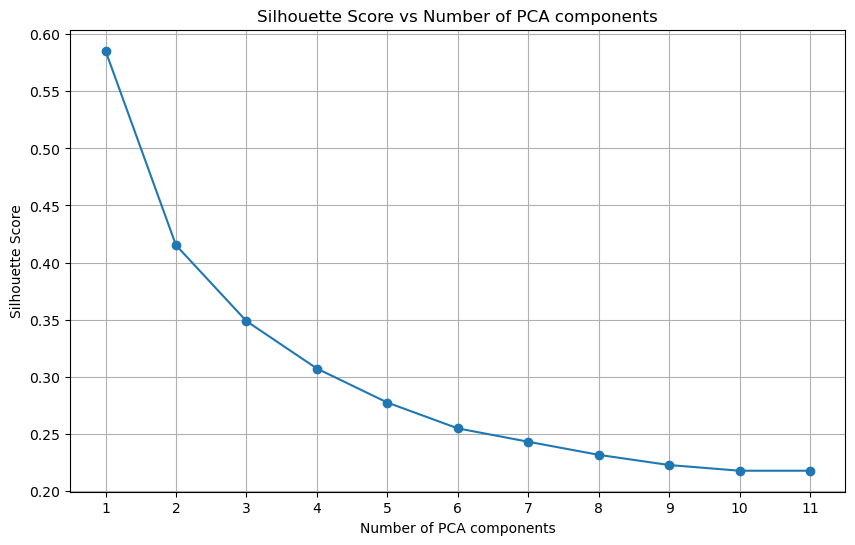

In [24]:
silhouette_scores = []
components_range = range(1, 12)

# Iterate over the range of PCA components
for y in components_range:
    print("PCA with # of components:", y)
    pca = PCA(n_components=y)
    data_p = pca.fit_transform(data)
    alg = KMeans(n_clusters=2, init='k-means++', random_state=42)
    label = alg.fit_predict(data_p)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(data_p, label)
    silhouette_scores.append(silhouette_avg)
    
    # Print silhouette score and inertia
    print('Silhouette-Score for 2 Clusters:', silhouette_avg, '       Inertia:', alg.inertia_)
    print()

# Plot the silhouette scores vs. number of PCA components
plt.figure(figsize=(10, 6))
plt.plot(components_range, silhouette_scores, marker='o')
plt.xlabel('Number of PCA components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of PCA components')
plt.xticks(components_range)
plt.grid(True)
plt.show()

In [25]:
def visualize_clusters(data, clustering_algorithm, algorithm_name, test_description, df, **kwargs):
    # Initialize the clustering algorithm
    if algorithm_name == 'KMeans':
        alg = clustering_algorithm(n_clusters=kwargs.get('num_clusters', 3), init='k-means++', random_state=42)
    elif algorithm_name == 'AHC':
        alg = clustering_algorithm(n_clusters=kwargs.get('num_clusters', 3))
    elif algorithm_name == 'DBSCAN':
        alg = clustering_algorithm(eps=kwargs.get('eps', 0.5), min_samples=kwargs.get('min_samples', 5))
    else:
        raise ValueError(f'Unsupported algorithm: {algorithm_name}')
    
    # Fit the clustering algorithm
    alg.fit(data)
    labels = alg.labels_

    # Get cluster centers if available
    cluster_centers = getattr(alg, 'cluster_centers_', None)
    
    # Save the cluster labels to the result dataframe
    df[f'Cluster_{algorithm_name}_{test_description}'] = labels

    # Calculate and print Silhouette Score and Davies-Bouldin Index
    if len(np.unique(labels)) > 1:  # Silhouette and Davies-Bouldin scores require at least 2 clusters
        silhouette_avg = silhouette_score(data, labels)
        davies_bouldin_avg = davies_bouldin_score(data, labels)
    else:
        silhouette_avg = -1  # Invalid score for single cluster
        davies_bouldin_avg = -1  # Invalid score for single cluster

    print(f'{algorithm_name} - {test_description}:')
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Index: {davies_bouldin_avg}')
    
    # Visualize the clusters
    plt.figure(figsize=(10, 6))
    if data.shape[1] == 1:
        plt.scatter(data[:, 0], np.zeros_like(data[:, 0]), c=labels, cmap='viridis', marker='o', label='Data Points')
        if cluster_centers is not None:
            plt.scatter(cluster_centers[:, 0], np.zeros_like(cluster_centers[:, 0]), s=300, c='red', label='Centroids', marker='x')
        plt.xlabel('PCA Component 1')
        plt.yticks([])  # Hide y-axis ticks since there's no variation in y
    else:
        plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', label='Data Points')
        if cluster_centers is not None:
            plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=300, c='red', label='Centroids', marker='x')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
    plt.title(f'{algorithm_name} Clustering {test_description}')
    plt.legend()
    plt.show()
    
    # Print the shape of the features and cluster centers for verification
    print(f'{algorithm_name}: Data shape: {data.shape}')
    if cluster_centers is not None:
        print(f'{algorithm_name}: Cluster centers shape: {cluster_centers.shape}')

def apply_pca_and_visualize(data, n_components, clustering_algorithm, algorithm_name, test_description, df, **kwargs):
    # Apply PCA to the dataset
    pca = PCA(n_components=n_components)
    data_p = pca.fit_transform(data)
    
    # Visualize the clusters
    visualize_clusters(data_p, clustering_algorithm, algorithm_name, test_description, df, **kwargs)

KMeans - Test 1:
Silhouette Score: 0.5995408467749396
Davies-Bouldin Index: 0.45667931353180635


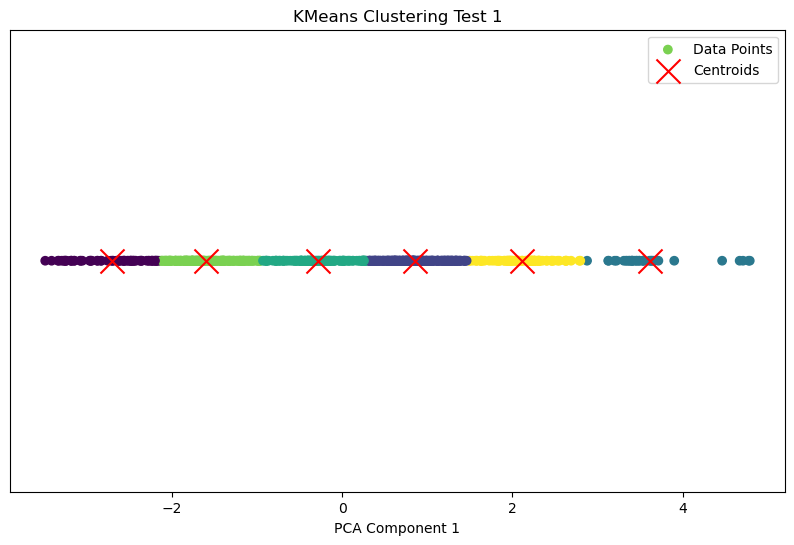

KMeans: Data shape: (800, 1)
KMeans: Cluster centers shape: (6, 1)


In [26]:
apply_pca_and_visualize(data_subset, n_components=1, clustering_algorithm=KMeans, algorithm_name='KMeans', test_description='Test 1', df=Clustering, num_clusters=6)

KMeans - Test 1:
Silhouette Score: 0.32121479919934165
Davies-Bouldin Index: 0.9332699411034199


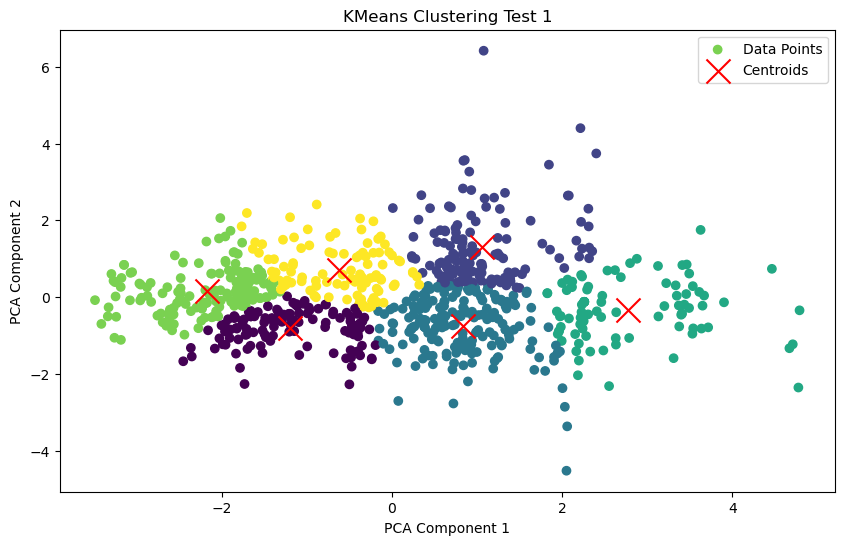

KMeans: Data shape: (800, 2)
KMeans: Cluster centers shape: (6, 2)


In [27]:
apply_pca_and_visualize(data_subset, n_components=2, clustering_algorithm=KMeans, algorithm_name='KMeans', test_description='Test 1', df=Clustering, num_clusters=6)

DBSCAN - Test 2:
Silhouette Score: 0.5489219975216215
Davies-Bouldin Index: 0.3076279752397561


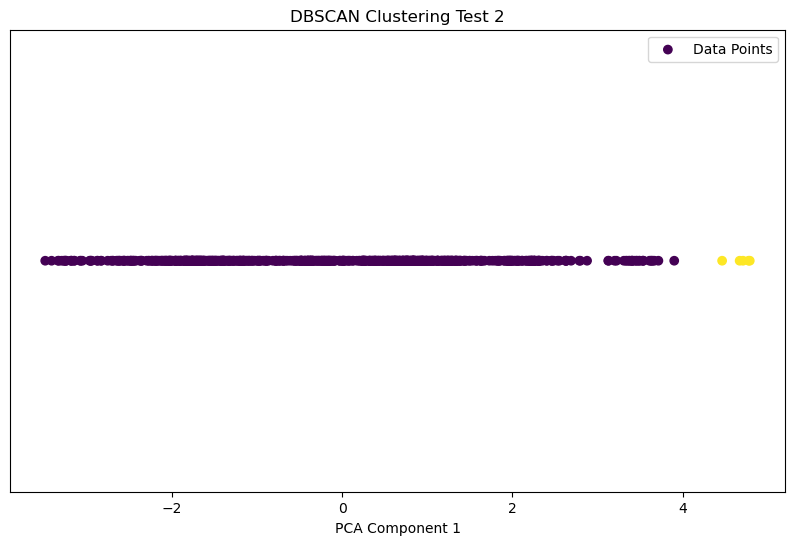

DBSCAN: Data shape: (800, 1)


In [28]:
apply_pca_and_visualize(data_subset, n_components=1, clustering_algorithm=DBSCAN, algorithm_name='DBSCAN', test_description='Test 2', df=Clustering, eps=0.5, min_samples=5)

DBSCAN - Test 3:
Silhouette Score: 0.312789034002225
Davies-Bouldin Index: 2.369825830560177


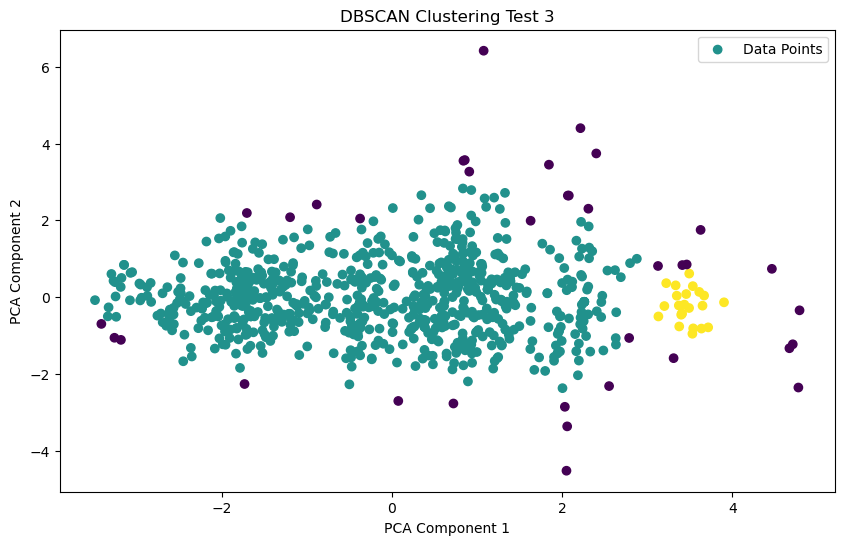

DBSCAN: Data shape: (800, 2)


In [29]:
apply_pca_and_visualize(data_subset, n_components=2, clustering_algorithm=DBSCAN, algorithm_name='DBSCAN', test_description='Test 3', df=Clustering, eps=0.5, min_samples=10)

AHC - Test 4:
Silhouette Score: 0.5196431747763725
Davies-Bouldin Index: 0.5436876057391058


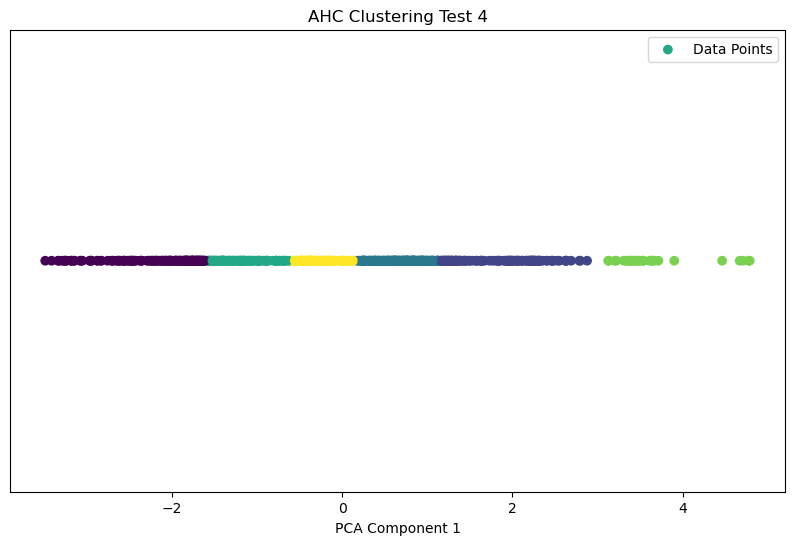

AHC: Data shape: (800, 1)


In [30]:
apply_pca_and_visualize(data_subset, n_components=1, clustering_algorithm=AgglomerativeClustering, algorithm_name='AHC', test_description='Test 4', df=Clustering, num_clusters=6, affinity='euclidean', linkage='single')

AHC - Test 4:
Silhouette Score: 0.30603215226816516
Davies-Bouldin Index: 0.9163511514409647


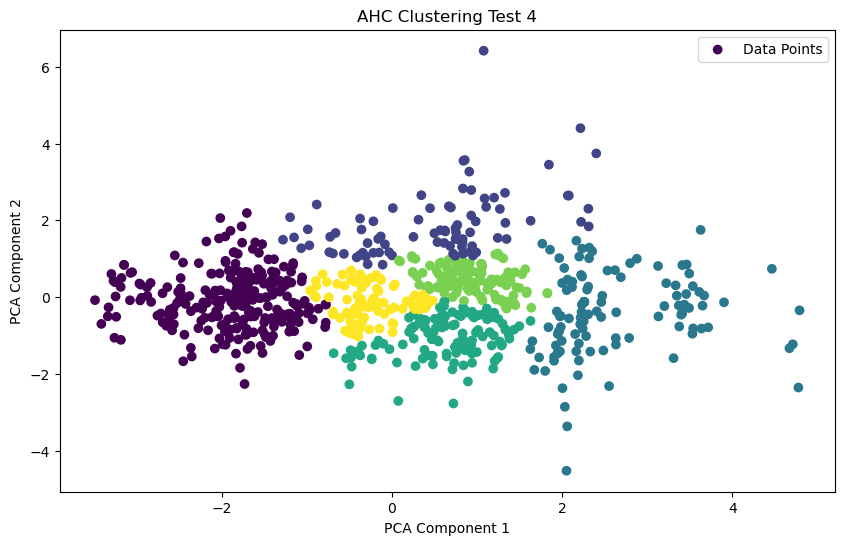

AHC: Data shape: (800, 2)


In [31]:
apply_pca_and_visualize(data_subset, n_components=2, clustering_algorithm=AgglomerativeClustering, algorithm_name='AHC', test_description='Test 4', df=Clustering, num_clusters=6, affinity='euclidean', linkage='single')